In [1]:
#Some packages needs to be installed in order to run this code
#Moving Pandas is the most complicated to install
#Get anaconda - create new environment
import re

import numpy as np
import json

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data

#import requests
import geojson
from pyproj import CRS
#from owslib.wms import WebMapService
#from owslib.wcs import WebCoverageService

#import scipy.stats as stats
#from scipy.signal import lfilter

import random

#Packages for PCA
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler

#Packages for interpreting elevation data
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

#MovingPandas (Kalman-filter)
#import movingpandas as mpd

import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
import shapely as shp
from shapely.geometry import box

from datetime import datetime, timedelta
from holoviews import opts, dim

import time

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}

import pickle

import matplotlib.colors as colors
from mycolorpy import colorlist as mcp


#import gurobipy as gp
#from gurobipy import GRB
import matplotlib.pyplot as plt
import math
from IPython.display import Image

import geocoder 

In [2]:
df = pd.read_csv('Data/all_airports.csv', index_col=0)
df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])

gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.set_crs('EPSG:4326', inplace=True)

,name,IATA-kod,ICAO-kod,pass_2019,pass_2020,geometry,status,type
0,Stockholm-Arlanda flygplats,ARN,ESSA,25 642 703,6 535 776,POINT (17.93862 59.64980),open,Swd
1,Göteborg-Landvetter flygplats,GOT,ESGG,6 671 361,1 576 787,POINT (12.28728 57.66451),open,Swd
2,Stockholm-Bromma flygplats,BMA,ESSB,2 354 051,479 400,POINT (17.94678 59.35703),open,Swd
3,Malmö Airport (Sturup),MMX,ESMS,1 975 842,526 154,POINT (13.37169 55.53546),open,Swd
4,Luleå-Kallax flygplats,LLA,ESPA,1 162 424,420 231,POINT (22.11975 65.54639),open,Swd
...,...,...,...,...,...,...,...,...
196,Älvdalen,NaN,NaN,NaN,NaN,POINT (14.03739 61.22990),open,NP
197,Älvsbyn-Högheden flygfält,NaN,ESUV,NaN,NaN,POINT (21.03561 65.63946),open,NP
198,Öresten flygfält,NaN,ESGM,NaN,NaN,POINT (12.64667 57.44444),open,NP
199,Östersund-Optand flygfält,NaN,ESNM,NaN,NaN,POINT (14.78265 63.12054),open,NP


## bad frame
So i got the data by just quering bing, which returns the top search result. But the returned coordinates might be wrong, the same way that if you type öresten into google maps you might not get the right place first go. But at least we ahve something to work with.

In [3]:
#here we can see that its not perfect :)
gdf[gdf.geometry.duplicated()]

,name,IATA-kod,ICAO-kod,pass_2019,pass_2020,geometry,status,type
23,Norrköping-Kungsängens flygplats,NRK,ESSP,103298,17 899,POINT (16.62720 59.60213),open,P
29,Sveg Härjedalens flygplats,EVG,ESND,5525,2 380,POINT (16.62720 59.60213),open,P
35,Ängelholm-Helsingborg flygplats,AGH,ESTA,386519,110 142,POINT (16.62720 59.60213),open,P
115,Linköping/Malmen flygplats,NaN,ESCF,NaN,NaN,POINT (16.62720 59.60213),open,NP
163,Såtenäs flygplats,NaN,ESIB,NaN,NaN,POINT (12.70076 58.44213),open,NP
173,Troslanda (Trosa),NaN,NaN,NaN,NaN,POINT (11.76534 57.72437),open,NP
188,Västerås/Johannisbergs flygfält,NaN,ESSX,NaN,NaN,POINT (16.54637 59.61110),open,NP


<AxesSubplot: >

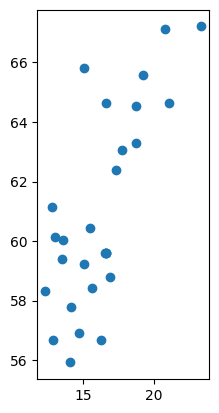

In [9]:
#gdf.hvplot(geo=True, tiles=True)
gdf.loc[gdf["type"]=="P"].plot()

In [22]:
#gdf.loc[gdf["pass_2019"].notna()].plot(markersize=gdf.loc[gdf["pass_2019"].notna()]["pass_2019"])

## realized that passengers was not in int :)

In [249]:
oldname = "pass_2019"
newname = "pass19"

gdf[newname] = np.nan

def clean(n):
    return int(re.sub("[^0-9]", "", n))

gdf.loc[gdf[oldname].notna(), newname] = gdf.loc[gdf[oldname].notna()][oldname].apply(lambda x: clean(x))

gdf.drop(oldname, axis=1, inplace=True)

In [251]:
oldname = "pass_2020"
newname = "pass20"

gdf[newname] = np.nan

def clean(n):
    return int(re.sub("[^0-9]", "", n))

gdf.loc[gdf[oldname].notna(), newname] = gdf.loc[gdf[oldname].notna()][oldname].apply(lambda x: clean(x))

gdf.drop(oldname, axis=1, inplace=True)

## not all airports have unique identifiers
we should come up with a naming system, but until then I drop these airports.

Also drop asll duplicates due to bad dataframe (and I think one because wikipedia named it twice)

In [ ]:
dist = gdf[["ICAO-kod", "geometry"]].copy()
dist.rename(columns={"ICAO-kod":"icao"},inplace=True)

In [193]:
dist.dropna(inplace=True)

In [194]:
dist.to_crs("EPSG:3009",inplace=True) #project on metric coordinate system

In [195]:
idx_l = dist.index.tolist()
for idx in idx_l:
    dist[dist.icao[idx]] = dist.distance(dist.geometry[idx])/1000

In [196]:
dist[dist.geometry.duplicated()].drop_duplicates(inplace=True)
dist[dist["icao"].duplicated()].drop_duplicates(inplace=True)

In [199]:
dist.set_index(["icao"],drop=True, inplace=True)

## dataframe with distances between all airports
dist [km]

In [205]:
dist = dist[dist.columns.tolist()[1::]+["geometry"]]

In [206]:
dist

,ESSA,ESGG,ESSB,ESMS,ESPA,ESNU,ESNZ,ESSV,ESNQ,ESDF,...,ESSX,ESUA,ESUJ,ESUS,ESMU,ESUV,ESGM,ESNM,ESNE,geometry
icao,,,,,,,,,,,,,,,,,,,,,
ESSA,0.000000,395.452635,32.630532,533.200543,691.571914,478.067009,74.206312,222.728883,918.797831,408.743588,...,78.685155,548.949764,342.632220,503.729684,408.134417,686.428761,393.915665,421.872942,784.778600,POINT (315669.312 6618725.083)
ESGG,395.452635,0.000000,379.816976,246.299984,1019.382321,809.087040,331.767393,361.509327,1202.270565,239.244027,...,328.852288,853.402307,579.902835,773.780633,165.410428,1000.492828,32.621768,623.229497,1109.731786,POINT (-11882.645 6397156.804)
ESSB,32.630532,379.816976,0.000000,506.337696,722.845698,509.686691,79.630232,190.269238,951.191982,379.345747,...,84.268638,581.293686,373.898283,536.331713,382.068948,718.293158,375.926614,452.409670,816.039871,POINT (317575.109 6586150.253)
ESMS,533.200543,246.299984,506.337696,0.000000,1212.130149,997.718713,492.902500,386.430800,1415.946018,143.894622,...,491.929437,1054.929213,794.845368,986.074729,126.123641,1199.815417,217.244399,848.774458,1304.702439,POINT (47194.951 6158046.955)
ESPA,691.571914,1019.382321,722.845698,1212.130149,0.000000,214.630732,719.970162,901.519559,265.908412,1097.968477,...,720.651738,173.152670,452.128737,273.818993,1086.186892,51.130994,1032.102800,445.801835,93.207679,POINT (478444.691 7290867.842)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESMU,408.134417,165.410428,382.068948,126.123641,1086.186892,871.721240,366.784748,281.030140,1292.084283,77.407409,...,365.832115,929.748639,672.596447,862.606800,0.000000,1074.284866,132.826634,729.498389,1178.823949,POINT (97974.989 6273496.341)
ESUV,686.428761,1000.492828,718.293158,1199.815417,51.130994,209.360999,709.818101,900.750858,245.460136,1089.580162,...,710.174507,147.189203,426.282122,239.952290,1074.284866,0.000000,1014.610882,412.029401,112.498978,POINT (427569.060 7295971.633)
ESGM,393.915665,32.621768,375.926614,217.244399,1032.102800,820.500354,333.912938,341.962475,1219.924395,207.105192,...,331.369883,867.763267,596.896738,790.560388,132.826634,1014.610882,0.000000,643.321862,1123.057117,POINT (8708.754 6371855.144)


## airports

In [234]:
ap = gdf.loc[gdf["pass19"].notna()].copy()

We assume all passengers come back, i.e. pass out = pass in

In [239]:
ap["pass"] = round(ap["pass19"]/2)

# Small test

In [253]:
test = gdf.loc[[0,1,2,3,4]]

In [257]:
test["pass"] = round(test["pass19"]/100000)

In [259]:
test = test[["name", "IATA-kod", "geometry", "pass"]].copy()

In [261]:
test.rename(columns={"IATA-kod":"IATA"}, inplace=True)


In [277]:
test_dist = test[["IATA","geometry"]]
test_dist = test_dist.to_crs("EPSG:3009") #project on metric coordinate system
idx_l = test_dist.index.tolist()
for idx in idx_l:
    test_dist[test_dist.IATA[idx]] = test_dist.distance(test_dist.geometry[idx])/1000
test_dist.set_index(["IATA"], inplace=True)
test_dist.drop("geometry", axis=1,inplace=True)

In [299]:
test_dist["ARN"]

IATA
ARN      0.000000
GOT    395.452635
BMA     32.630532
MMX    533.200543
LLA    691.571914
Name: ARN, dtype: float64

In [302]:
test_dist

,ARN,GOT,BMA,MMX,LLA
IATA,,,,,
ARN,0.000000,395.452635,32.630532,533.200543,691.571914
GOT,395.452635,0.000000,379.816976,246.299984,1019.382321
BMA,32.630532,379.816976,0.000000,506.337696,722.845698
MMX,533.200543,246.299984,506.337696,0.000000,1212.130149
LLA,691.571914,1019.382321,722.845698,1212.130149,0.000000


In [305]:
test_dist.to_numpy()

array([[   0.        ,  395.45263527,   32.63053188,  533.200543  ,
         691.57191408],
       [ 395.45263527,    0.        ,  379.81697636,  246.29998388,
        1019.38232057],
       [  32.63053188,  379.81697636,    0.        ,  506.3376963 ,
         722.8456975 ],
       [ 533.200543  ,  246.29998388,  506.3376963 ,    0.        ,
        1212.13014885],
       [ 691.57191408, 1019.38232057,  722.8456975 , 1212.13014885,
           0.        ]])

In [353]:
test_pass = test[["IATA","pass"]].copy()
#test_pass.set_index(["IATA"], inplace=True)

In [354]:
test_pass["ARN"] = [0,56,15,14,6]
test_pass["GOT"] = [56,0,5,3,3]
test_pass["BMA"] = [15,5,0,2,2]
test_pass["MMX"] = [14,3,2,0,1]
test_pass["LLA"] = [6,3,2,1,0]


test_pass.set_index(["IATA"], inplace=True)
test_pass.drop("pass", axis=1,inplace=True)

In [356]:
test_pass.to_numpy()

array([[ 0, 56, 15, 14,  6],
       [56,  0,  5,  3,  3],
       [15,  5,  0,  2,  2],
       [14,  3,  2,  0,  1],
       [ 6,  3,  2,  1,  0]])